# Covariance Matrix preparation
In this notebook, we try to implement the covariance matrix preparation via ensemble average density matrix, as proposed in ["Covariance Matrix Preparation for Quantum Principal Component Analysis"](https://doi.org/10.1103/PRXQuantum.3.030334) by Gordon et al, 2022.

In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.linalg import expm
from collections import defaultdict
from IPython.display import display
from keras.datasets import mnist
import random

from qiskit_aer import *
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, PhaseEstimation
from qiskit.circuit.library.data_preparation import StatePreparation
from qiskit.quantum_info import DensityMatrix

import qPCA_funcs as QF

Loading the MNIST handwritten digit dataset:

In [2]:
#checking that the dataset loading works
(X, y), _ = mnist.load_data()

# take subset of 5000 images
idx = np.random.choice(np.arange(y.shape[0]), size=5000, replace=False)
X=X[idx,:,:]
y=y[idx]

#printing the shapes of the vectors 
print('X: ' + str(X.shape))
print('Y: ' + str(y.shape))

# check that the labels are balanced
nums, counts = np.unique(y, return_counts=True)
for n, c in zip(nums, counts):
    print(f"{n}: {c} counts")

# we need to flatten the images into a 1D vector each
# so X is a 2D array
X = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
print(X.shape)
# compute covariance matrix
cov_matr = np.cov(X, rowvar=False)
print(f'Covariance matrix shape: {cov_matr.shape}')

X: (5000, 28, 28)
Y: (5000,)
0: 494 counts
1: 554 counts
2: 535 counts
3: 540 counts
4: 468 counts
5: 416 counts
6: 461 counts
7: 513 counts
8: 531 counts
9: 488 counts
(5000, 784)
Covariance matrix shape: (784, 784)


Ok let's try something:

In [3]:
def amp_encode(vec):
    # vec is an input data vector
    # padded to len 2**n if necessary
    qc = QuantumCircuit(len(vec).bit_length()-1)
    qc.append(StatePreparation(vec), qc.qubits)
    return qc

# randomly sampling from ensemble
def estimate_rho_circuit(X_padded, N_samples):
    # given a list of data vectors
    # randomly picks one, encodes amplitude & returns the density matrix
    # which is averaged (no idea if this is even close to correct)
    rho_accum = None
    for _ in range(N_samples):
        i = random.randrange(len(X_padded))
        qc = amp_encode(X_padded[i])
        # directly simulates dm
        # or should I do this differently?
        dm = DensityMatrix.from_instruction(qc)
        rho_accum = dm if rho_accum is None else rho_accum + dm

    return rho_accum / N_samples

N_test = 50
zero_mask = np.linalg.norm(X, axis=1) != 0
# normalize
norms = np.linalg.norm(X[zero_mask], axis=1)
X_normalized = X.copy().astype(float)
X_normalized[zero_mask] /= norms[:, np.newaxis]
# zero padding
dim = len(X[0])
new_dim =2**int(np.ceil(np.log2(dim)))
X_padded = np.zeros((X.shape[0], new_dim))
X_padded[:, :dim] = X_normalized
# create encoder circuits
# estimate rho
rho = estimate_rho_circuit(X_padded, N_test)
# took ~1300s to run

In [4]:
print(rho)

DensityMatrix([[-1.30283666e-018-6.55374347e-020j,
                -8.12453547e-033+3.15415566e-032j,
                -1.12290548e-032+2.80224355e-033j, ...,
                 1.27738795e-109+1.93737173e-109j,
                 6.04630297e-109+4.19409044e-109j,
                 2.06336538e-122+2.22371489e-122j],
               [-7.29648663e-033+2.79701999e-032j,
                -8.10568817e-034-9.14780613e-034j,
                 3.12685166e-047+8.43920614e-046j, ...,
                 6.33130650e-110-6.50744048e-110j,
                -1.15249793e-123-1.77804809e-123j,
                 9.43566587e-124+1.46323189e-124j],
               [-1.14077382e-032-3.35065480e-033j,
                -1.10195416e-046+5.64917260e-046j,
                 1.75753224e-033-6.11564048e-035j, ...,
                 2.42036995e-124+2.11782370e-123j,
                 1.30560521e-110-5.85725886e-111j,
                 6.14547057e-124-1.67345891e-124j],
               ...,
               [ 5.18249563e-110-1.47267605e

In [5]:
# let's test this:
U_mat = expm(-1j * rho * 2*np.pi)
U = UnitaryGate(U_mat, label="U")

Resolution: 4
# qubits for PE: 14
Phase Estimation circuit:


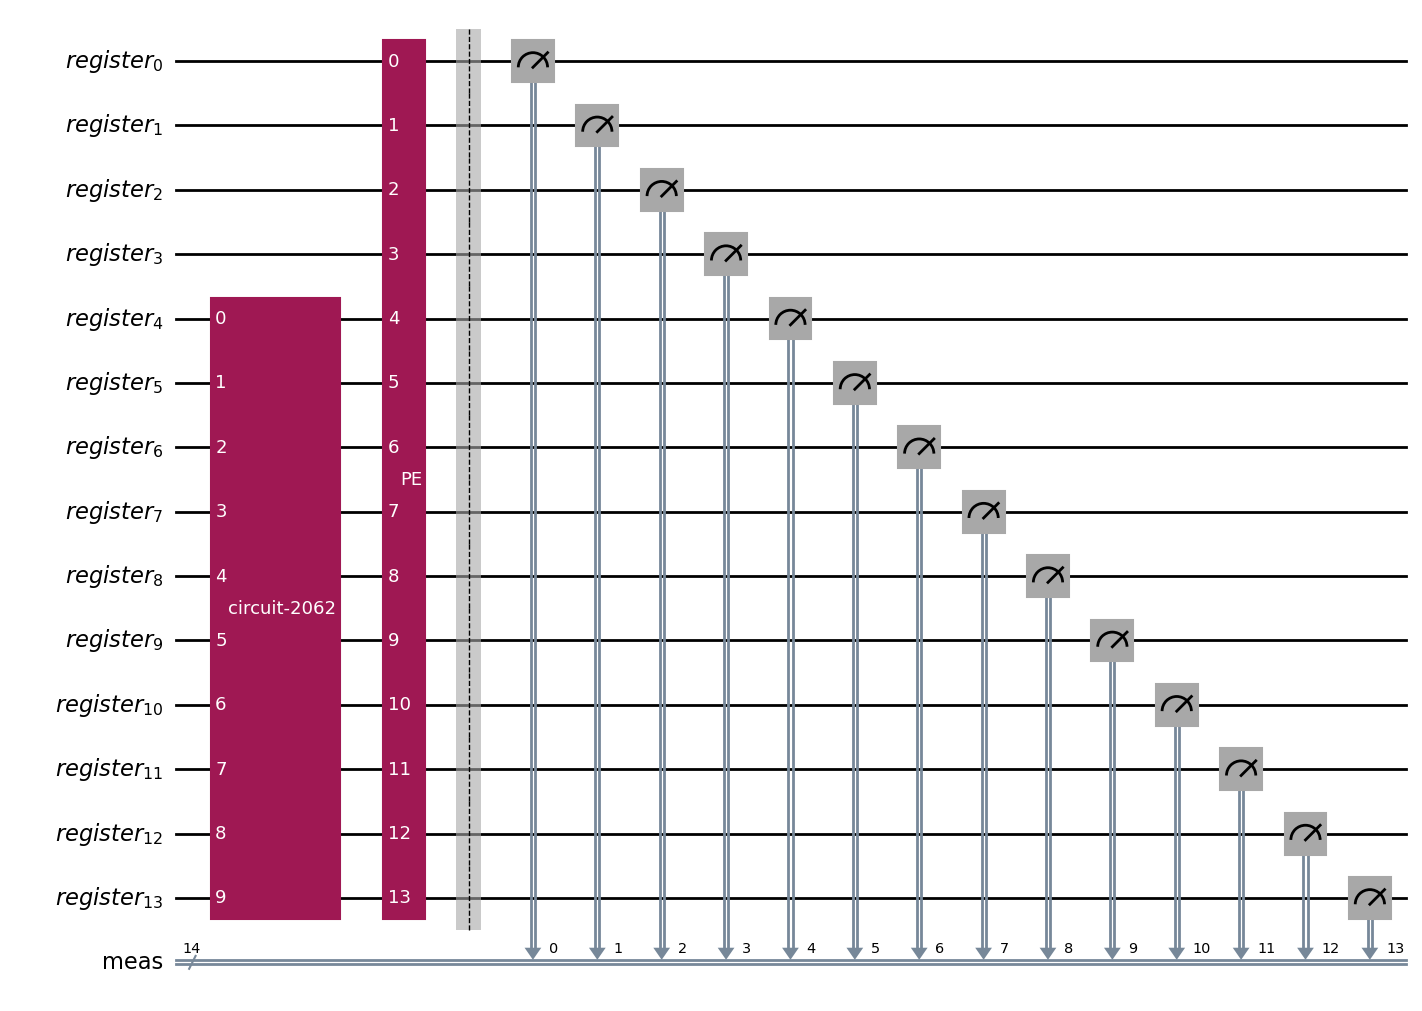

In [6]:
nsys = int(np.log2(new_dim))
resolution = 4
verbose = True
qc_init = QuantumCircuit(nsys)
simulator = AerSimulator(method="density_matrix")
pe_circuit = QF.build_PE_circuit(qc_init, U, resolution=resolution, verbose=verbose)

In [ ]:
n_shots=1024
plot_results=verbose
norm_factor=1
# transpile the circuit
pe_transpiled = transpile(pe_circuit, simulator)
# run circuit
pe_result = simulator.run(pe_transpiled, initial_state=rho, shots=n_shots).result()
# get counts
pe_counts = pe_result.get_counts()

# plotting the counts if desired
if plot_results:
    print("PE result counts:")
    plot = plot_histogram(pe_counts, figsize=(25, 5))
    display(plot)

# compute probailities from counts
if verbose: print("\nProbability estimation...")
probabilities = QF.probability_estimation(pe_counts, pe_circuit.num_qubits, n_shots)

In [ ]:
# rest to follow
def sign_estimation(pe_circuit, init_circuit, rho, probabilities, simulator=AerSimulator(), n_shots=50000, verbose=False):
    """
    Estimates the signs (+1 or -1) of the amplitude coefficients. Constructs and runs a sign estimation circuit from the PE
    and state preparation circuits.

    Parameters:
        pe_circuit (QuantumCircuit): Phase estimation circuit.
        init_circuit (QuantumCircuit): Input state preparation circuit.
        probabilities (dict): Dict of estimated probabilities for each state.
        simulator (Backend, optional): Simulator backend to use for running the circuit. Default: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        verbose (bool, optional): Whether to print debug information, plot circuit diagram and measurement histogram. Default: False.

    Returns:
        dict: Dictionary mapping states to signs (+1 or -1).
    """
    # adjust PE circuit for sign estimation
    pe_circuit.remove_final_measurements() # remove measurements
    
    # prepare unitaries
    U_p = StatePreparation(np.sqrt(list(probabilities.values())),label='U_p').control()
    
    # for U_x, we can't use to_gate bc of StatePreparation
    # so we seperate these parts
    # let's hope this works
    del pe_circuit.data[0] # this is wonky but ok
    # to check:
    if verbose:
        print("PE circuit data :")
        print(pe_circuit.data)
        
    # TODO: give the init to the funciton or figure out how to extract!!!!!!   
    U_x_init = init_circuit.control()
    U_x = pe_circuit.to_gate(label='U_x').control()

    n_qubits_pe = pe_circuit.num_qubits
    resolution = n_qubits_pe-init_circuit.num_qubits

    # prepare the sign estimation circuit
    target_register = QuantumRegister(n_qubits_pe, name='Target')
    control_register = QuantumRegister(1, name='Control')
    se_circuit = QuantumCircuit(target_register, control_register, name='SE')
    # add gates
    se_circuit.h(control_register)
    se_circuit.x(control_register)
    se_circuit.append(U_x_init, control_register[:]+target_register[resolution:n_qubits_pe])
    se_circuit.append(U_x, control_register[:]+target_register[:])
    se_circuit.x(control_register)
    se_circuit.append(U_p, control_register[:]+target_register[:])
    se_circuit.h(control_register)
    se_circuit.measure_all()

    if verbose:
        print("Sign estimation circuit:")
        # draw se circuit
        display(se_circuit.draw('mpl'))

    # Run the circuit using Aer simulator
    se_transpiled = transpile(se_circuit, simulator)
    
    # run with N shots
    se_result = simulator.run(se_transpiled, initial_state=rho, shots=n_shots).result()
    se_counts = se_result.get_counts()

    if verbose: #TODO: or seperate flag for plotting??
        print("SE result counts:")
        plot = plot_histogram(se_counts, figsize=(25, 5))
        display(plot)

    # filter for counts with Control qubit equal 0
    se_counts_filtered = {state[1:]: counts for state, counts in se_counts.items() if state[0]=='0'}
    # pad with zeros?
    # not sure if necessary or correct
    se_counts_filtered = QF.complete_counts(se_counts_filtered, se_circuit.num_qubits-1)
    # compare to find signs:
    sign_dict = {}
    for state, counts in se_counts_filtered.items():
        if counts > 0.4*n_shots*probabilities[state]:
            sign_dict[state] = 1
        else:
            sign_dict[state] = -1
            
    return sign_dict    

In [ ]:
# estimate the signs 
if verbose: print("\nSign estimation...")
sign_dict = sign_estimation(pe_circuit, qc_init, rho, probabilities, simulator=simulator, n_shots=n_shots, verbose=verbose)


In [ ]:
# construct eigenvectors and eigenvalues from results
if verbose: print("\nEigenvalue and -vector construction...")
eigvals, eigvecs = QF.eigen_construction(probabilities, sign_dict, resolution, qc_init.num_qubits, peak_threshold=0.001, verbose=verbose)

# rescale with norm_factor
eigvals = norm_factor * np.array(eigvals)

# print to check
if verbose:
    for val, vec in zip(eigvals, eigvecs):
        print(f'Eigenvalue: {val.round(3)}, eigenvector: {vec.round(3)}')
    print("Done!")